In [3]:
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import YOLOv1
from dataset import COCODataset, print_sample
from utils import (
    convert_cellboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from train import Compose
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from loss import YoloLoss
from collections import Counter

# Parameters

In [2]:
hp = {
    # model config
    'S': 4,
    'B': 2,
    'dropout': 0.5,
    'image_size': 88,
    # training config
    'lr': 2e-5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 32,
    'weight_decay': 0,
    'num_epochs': 300,
    'num_worker': 0,
    'Pin_memory': True,
    'load_model': True,
    'load_model_file': 'overfit.pth.tar',
    'max_training_samples': 70000,
    # loss config
    'lambda_coord': 5,
    'lambda_noobj': 0.5,
    # validation config 
    'threshold':0.4,
    'iou_threshold':0.5,
    'validation_batches':10
}

# Util Functions

In [3]:
def non_max_suppression(bboxes, threshold):
    assert type(bboxes) == list
    bboxes = [box for box in bboxes if box[0] > threshold]
    return bboxes

In [4]:
def cellboxes_to_boxes(out, S=hp['S']):
    converted_pred = convert_cellboxes(out,S)
    converted_pred = converted_pred.reshape(out.shape[0], S * S, -1)
    return converted_pred.tolist()

In [5]:
def intersection_over_union(boxes_preds, boxes_labels):
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [6]:
def get_average_precision(
        loader,
        model,
        iou_threshold=0.5,
        threshold=0.4,
        split_size=hp['S'],
        validation_batches = 3,
        batch_size = 8):
    
    model.eval()
    epsilon = 1e-6
    
    #----------------------- Collect detections and ground truths ---------------------------#
    
    detections = []
    ground_truths = []
    
    for batch_idx, (x,y) in enumerate(loader):
        # shape y [batch_size,S,S,10]
        # shape x [batch_size,S*S*10]
        # Only compute for a fraction of images
        if batch_idx >= validation_batches:
            break
        x = x.to(hp['device'])
        y = y.to(hp['device'])
        
        with torch.no_grad():
            preds = model(x)
            
        # iterate over batches
        for idx,pred in enumerate(preds):
            preds = pred.view([hp['S']*hp['S']*2,5])
            # reshape labels
            labels = torch.flatten(y[idx])
            labels = labels.view([hp['S']*hp['S']*2,5])
            # only get true labels
            labels = labels[labels[:,0]==1]
            # append image index in row
            if len(labels) != 0:
                index = torch.unsqueeze(torch.full([labels.shape[0]],(batch_idx*batch_size)+idx),1).to(hp['device'])
                labels = torch.cat((index,labels),1)
                for label in labels:
                    ground_truths.append(label.tolist())
            index = torch.unsqueeze(torch.full([hp['S']*hp['S']*2],(batch_idx*batch_size)+idx),1).to(hp['device'])
            preds = torch.cat((index,preds),1)
            for pred in preds:
                if pred[1] > threshold:
                    detections.append(pred.tolist())
            # pred and label shape = [n,6] [n,[image_index,prob,x1,x2,w,h]]

    model.train()
            
    #----------------------- Calculate the average precision ---------------------------#
        
    # find the amount of bboxes for each training example
    # Counter here finds how many ground truth bboxes we get
    # for each training example, so let's say img 0 has 3,
    # img 1 has 5 then we will obtain a dictionary with:
    # amount_bboxes = {0:3, 1:5}
    amount_bboxes = Counter([gt[0] for gt in ground_truths])
    # We then go through each key, val in this dictionary
    # and convert to the following (w.r.t same example):
    # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
    for key, val in amount_bboxes.items():
        amount_bboxes[key] = torch.zeros(val)
    # sort by box probabilities which is index 1
    detections.sort(key=lambda x: x[1], reverse=True)
    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)
    # If none exists for this class then we can safely skip
    if total_true_bboxes == 0:
        return 0

    for detection_idx, detection in enumerate(detections):
        # Only take out the ground_truths that have the same
        # training idx as detection
        ground_truth_img = [
            bbox for bbox in ground_truths if bbox[0] == detection[0]
        ]
        best_gt_idx = 0
        best_iou = 0
        for idx, gt in enumerate(ground_truth_img):
            iou = intersection_over_union(
                torch.tensor(detection[2:]),
                torch.tensor(gt[2:]),
            )
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou > iou_threshold:
            # only detect ground truth detection once
            if amount_bboxes[detection[0]][best_gt_idx] == 0:
                # true positive and add this bounding box to seen
                TP[detection_idx] = 1
                amount_bboxes[detection[0]][best_gt_idx] = 1
            else:
                FP[detection_idx] = 1
        # if IOU is lower then the detection is a false positive
        else:
            FP[detection_idx] = 1
    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))
    # torch.trapz for numerical integration
    return torch.trapz(precisions, recalls)

## Load Dataset

In [7]:
transform = Compose([transforms.Resize((hp['image_size'], hp['image_size'])), transforms.ToTensor()])

### Load Training Data

In [8]:
train_dataset_100 = COCODataset(transform=transform)
train_dataset_100.load_dataset()

Found annotations at 'C:\Users\vonbr\fiftyone\coco-2017\raw\instances_train2017.json'
Only found 64115 (<70000) samples matching your requirements
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading 'coco-2017' split 'train'
 100% |█████████████| 64115/64115 [5.4m elapsed, 0s remaining, 221.1 samples/s]      
Dataset 'coco-2017-train-70000' created


In [9]:
train_loader = DataLoader(  dataset=train_dataset_100, batch_size=hp["batch_size"], num_workers=hp["num_worker"],
                            pin_memory=hp["Pin_memory"], shuffle=True, drop_last=False)
print(f"Train loader initialized with: batch_size={hp['batch_size']} on device: {hp['device']}")

Train loader initialized with: batch_size=32 on device: cuda


#### Print Stats

Training samples: 64115
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 4., 4., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0

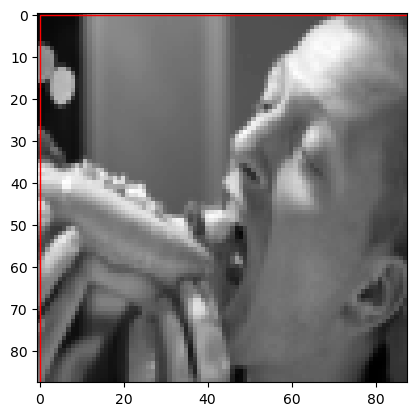

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

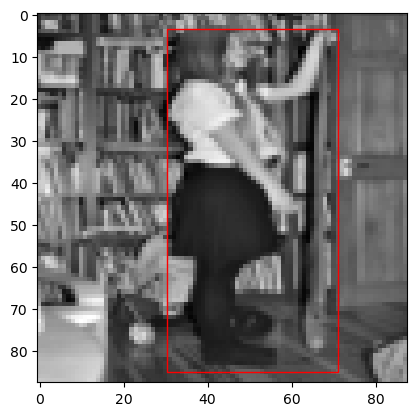

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.2719, 0.9146, 1.7123, 3.8293, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

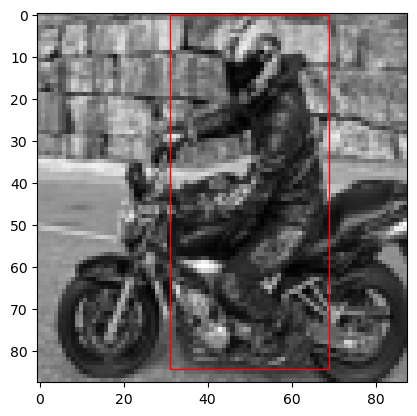

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.2870, 0.8719, 1.3966, 2.7783, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

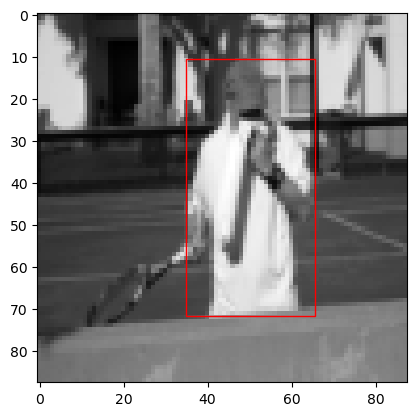

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.4438, 0.7658, 0.5355, 0.9771, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

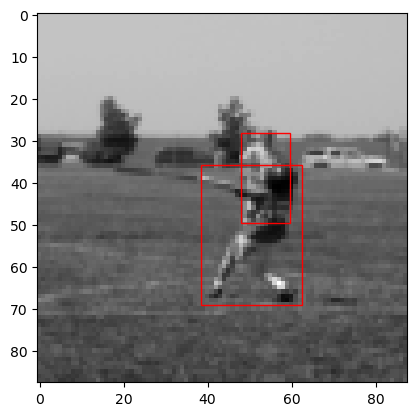

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

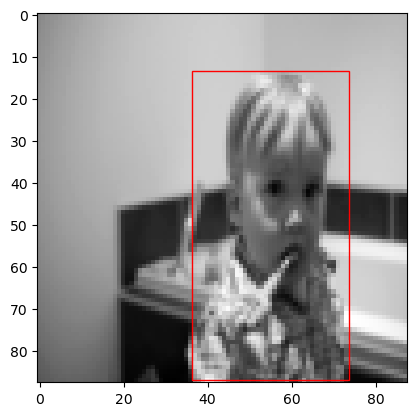

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0,

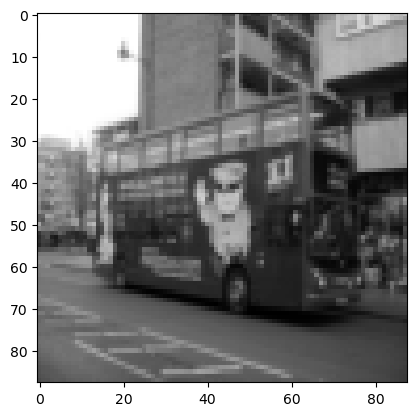

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.8505, 0.9726, 3.7010, 3.9453, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

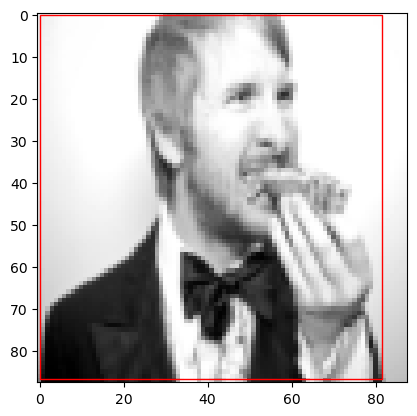

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0,

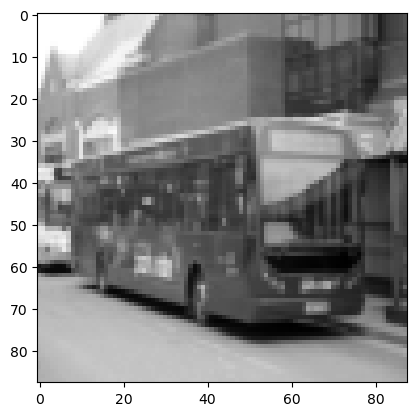

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.8817, 0.1208, 1.5038, 3.6539, 0.0000, 0.0000, 0.0000,
          0.0

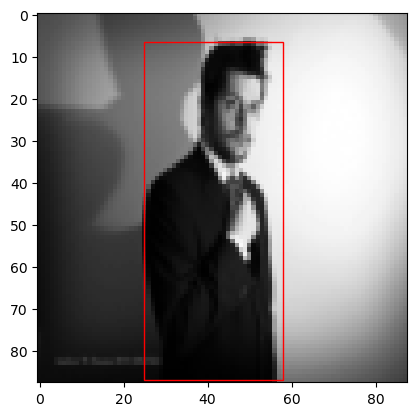

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

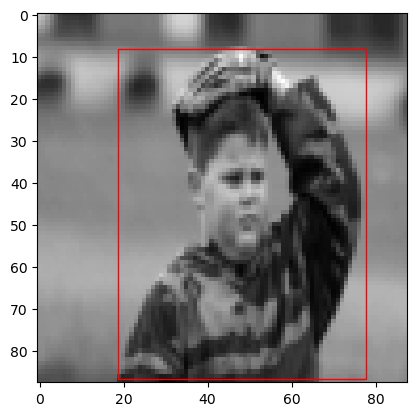

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

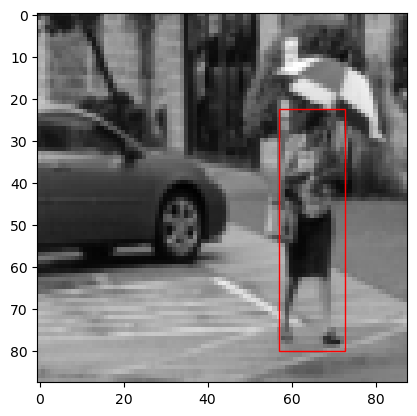

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.8848, 0.7019, 0.7517, 2.5689, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

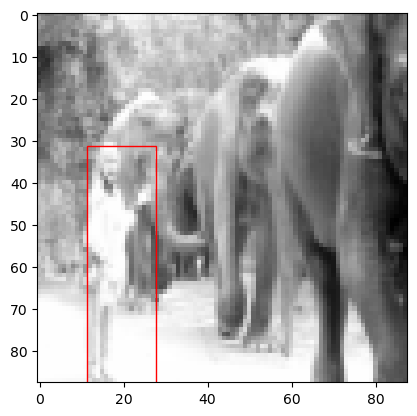

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.9122, 0.9001, 0.7548, 1.6786, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

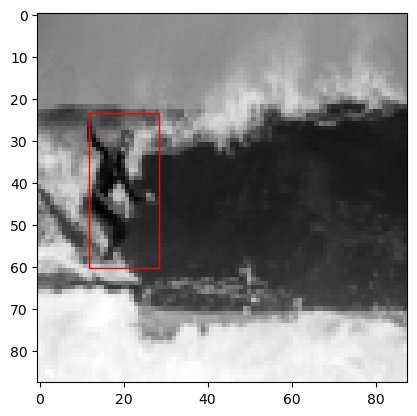

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0,

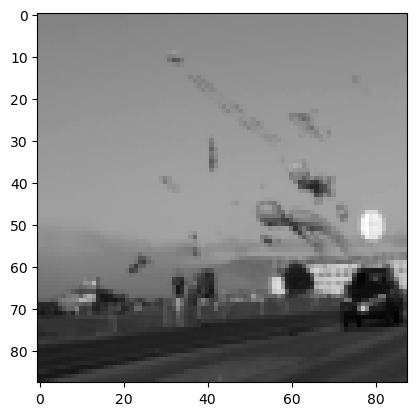

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.8984, 0.1446, 0.6590, 1.3697, 0.0000, 0.0000, 0.0000,
          0.0

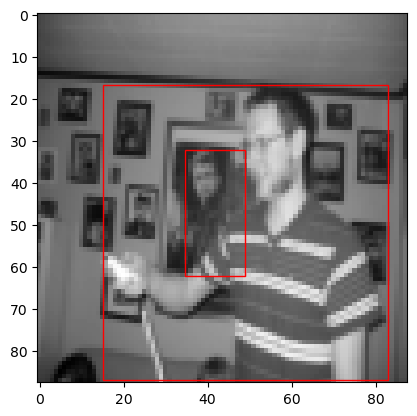

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.8687, 0.1456, 1.6710, 1.6539, 0.0000, 0.0000, 0.0000,
          0.0

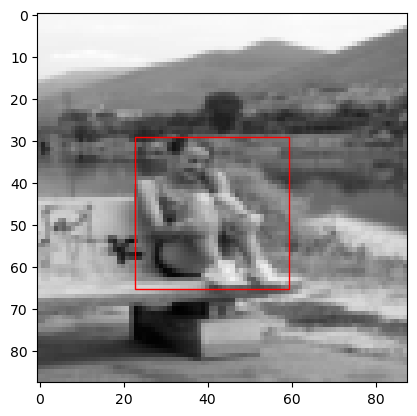

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

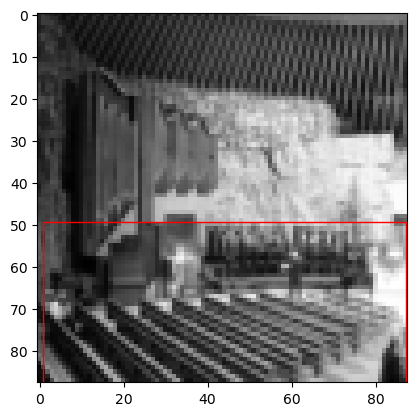

tensor([[[1.0000, 0.4680, 0.4516, 0.4797, 0.5502, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.3905, 0.9577, 0.5275, 0.4341, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.0935, 0.7319, 0.5726, 0.6420, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.6583, 0.6602, 0.4286, 0.5577, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.7992, 0.4874, 0.7022, 0.4527, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.1371, 0.1620, 0.5704, 0.4818, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

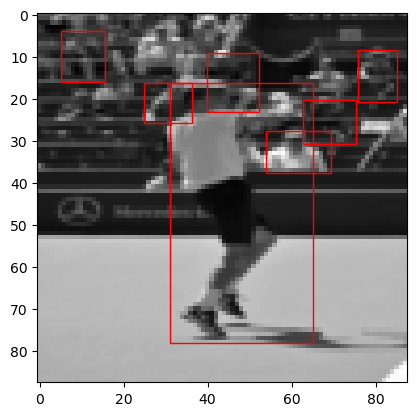

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

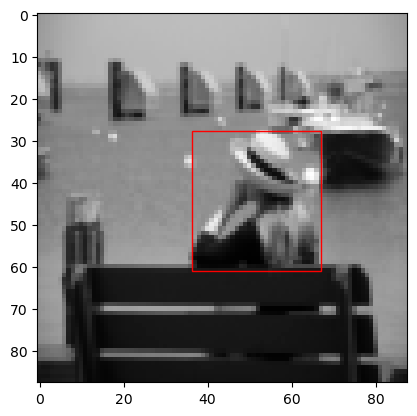

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.8219, 0.5480, 0.6562, 0.7026, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.6747, 0.6607, 1.2294, 1.7798, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.6343, 0.8764, 0.8576, 1.3483, 0.0000, 0.0000, 0.0000,
          0.0

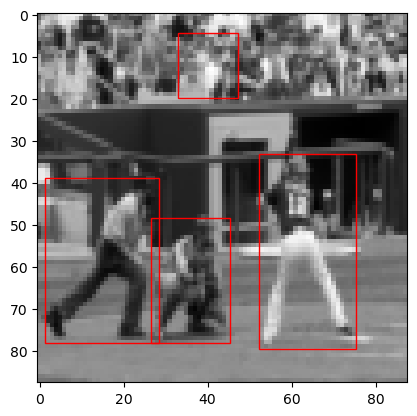

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.6582, 0.6187, 1.5293, 2.6696, 0.0000, 0.0000, 0.0000,
          0.0

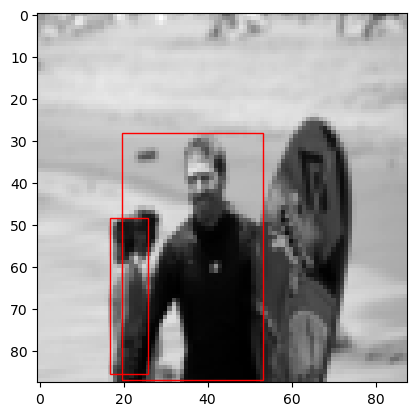

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.7403, 0.9209, 0.5504, 2.0568, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.3382, 0.8899, 0.6269, 2.0764, 0.0000, 0.0000, 0.0000,
          0.0

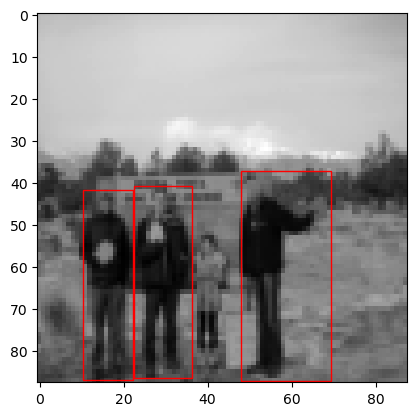

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.3116, 0.6443, 0.5103, 0.8425, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.7750, 0.7220, 0.4914, 0.5892, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.4440, 0.4147, 0.5041, 0.9485, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.9597, 0.3826, 0.6012, 0.8015, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.5469, 0.3944, 0.4869, 1.2884, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.8022, 0.9341, 1.6045, 2.1110, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

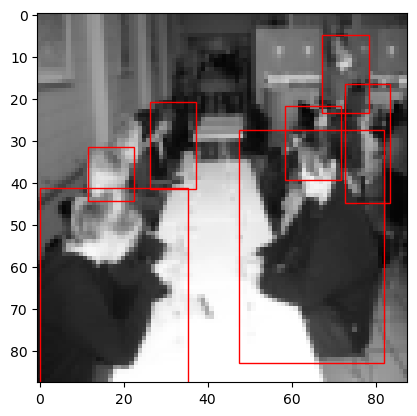

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0,

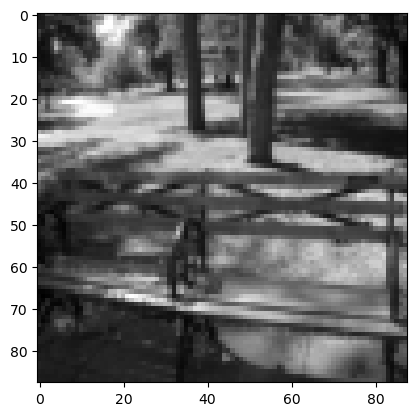

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.9836, 0.9955, 0.9296, 3.2899, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

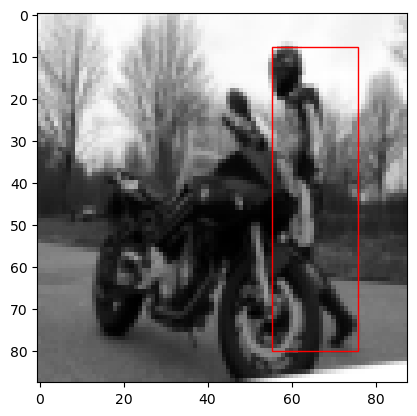

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.7343, 0.8459, 1.0378, 2.9693, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.2167, 0.4309, 0.9474, 2.7843, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

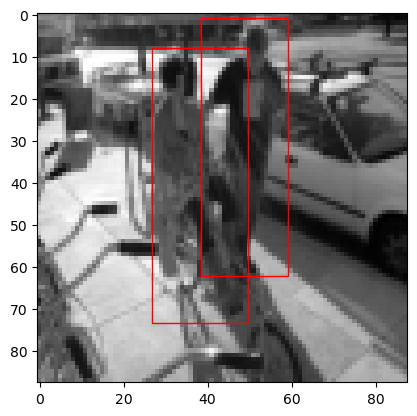

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.7868, 0.5637, 0.7922, 1.2987, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.7124, 0.9034, 1.4008, 1.4742, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

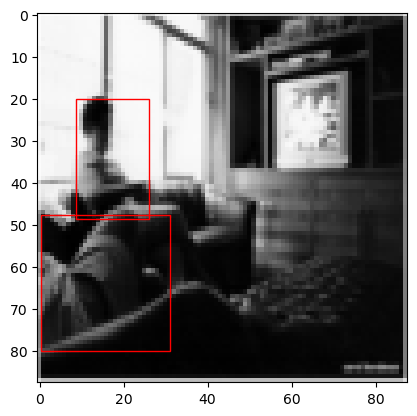

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0,

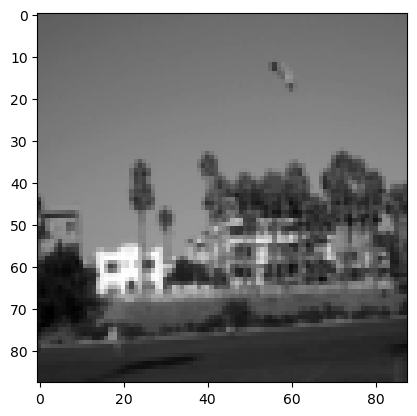

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.6834, 0.2796, 0.5169, 0.8647, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.0000, 0.2117, 0.1974, 2.3766, 3.5013, 0.0000, 0.0000, 0.0000,
          0.0

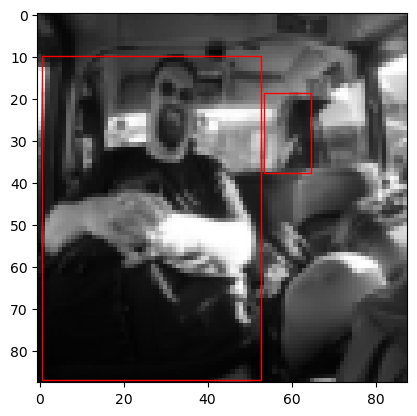

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

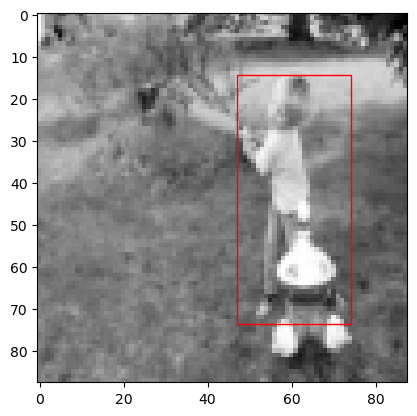

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[1.0000, 0.8701, 0.8548, 0.4538, 1.3935, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0

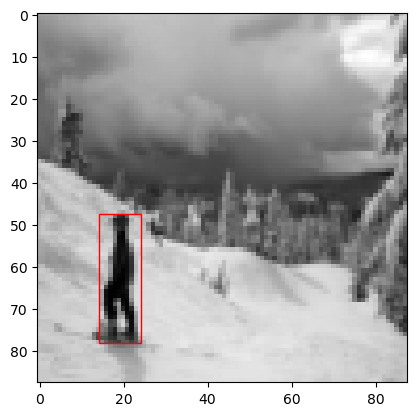

In [10]:
print(f"Training samples: {len(train_dataset_100)}")
# Display the first batch samples with true boxes
for x,y in train_loader:
    for idx in range(hp['batch_size']):
        print(y[idx])
        real_boxes = cellboxes_to_boxes(y.flatten(start_dim=1),hp['S'])
        print(f"Image shape: {x[idx].shape}")
        print(f"Box shape: {len(real_boxes[idx])}")
        print(f"The first Boxes are: {real_boxes[idx]}")
        plot_image(x[idx].permute(1,2,0).to("cpu"), real_boxes[idx])
    break

### Load Validation Data

In [11]:
val_dataset_100 = COCODataset(transform=transform)
val_dataset_100.load_dataset("validation")

Found annotations at 'C:\Users\vonbr\fiftyone\coco-2017\raw\instances_val2017.json'
Only found 2693 (<70000) samples matching your requirements
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 2693/2693 [13.1s elapsed, 0s remaining, 224.2 samples/s]      
Dataset 'coco-2017-validation-70000' created


In [12]:
val_loader = DataLoader(dataset=val_dataset_100, batch_size=hp["batch_size"], num_workers=hp["num_worker"],
                          pin_memory=hp["Pin_memory"], shuffle=True, drop_last=False)

#### Print Stats

In [13]:
print(f"Validation samples: {len(val_dataset_100)}")

Validation samples: 2693


Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.3502812385559082, 0.08668224513530731, 0.12256249785423279, 0.14957943558692932], [1.0, 0.7278359532356262, 0.21212616562843323, 0.22951562702655792, 0.27140188217163086], [1.0, 0.9069530963897705, 0.15433411300182343, 0.10400000214576721, 0.24908877909183502], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


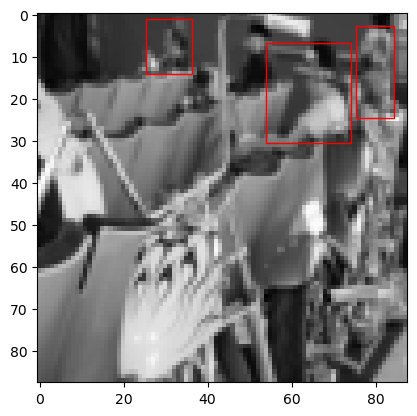

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [1.0, 0.5334843993186951, 0.721027672290802, 0.20784375071525574, 0.40893280506134033], [1.0, 0.7851874828338623, 0.7204347848892212, 0.39228126406669617, 0.40624505281448364], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


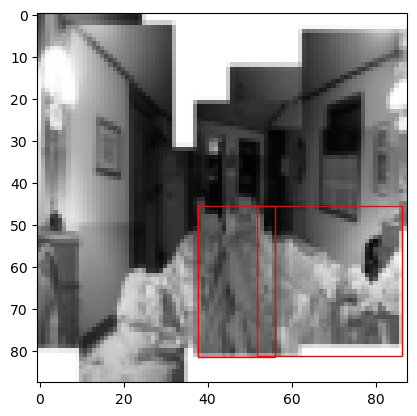

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [1.0, 0.3102230131626129, 0.3872343897819519, 0.10917840152978897, 0.11443749815225601], [1.0, 0.6438380479812622, 0.4272109270095825, 0.4380047023296356, 0.5383281111717224], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


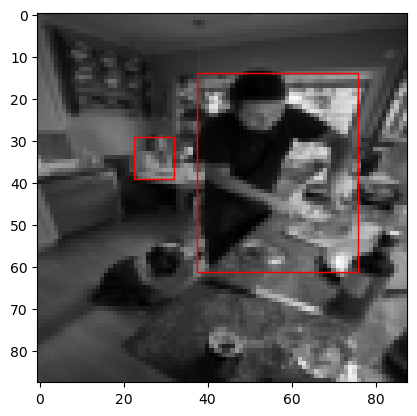

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


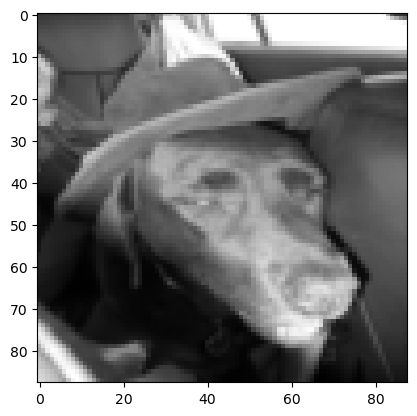

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [1.0, 0.20594531297683716, 0.37838542461395264, 0.4118906259536743, 0.7567708492279053], [1.0, 0.4011250138282776, 0.27528125047683716, 0.2460625022649765, 0.5505625009536743], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


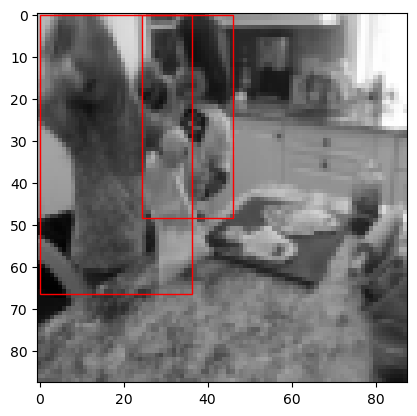

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [1.0, 0.28903907537460327, 0.5193554759025574, 0.33720311522483826, 0.9526953101158142], [1.0, 0.6151484251022339, 0.5908203125, 0.1359531283378601, 0.22566406428813934], [1.0, 0.7730703353881836, 0.6382421851158142, 0.3076718747615814, 0.33812499046325684], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


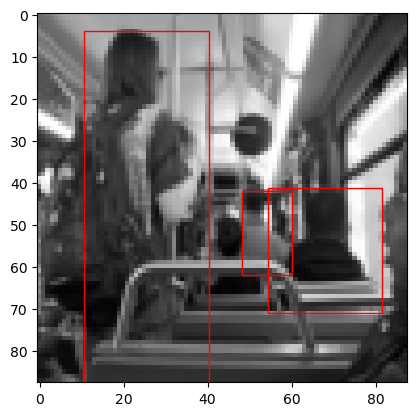

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [1.0, 0.13010156154632568, 0.7382721304893494, 0.2569531202316284, 0.5234557390213013], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


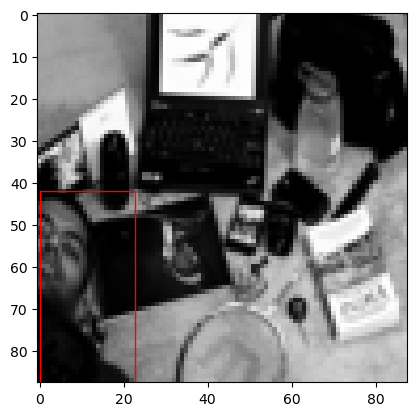

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


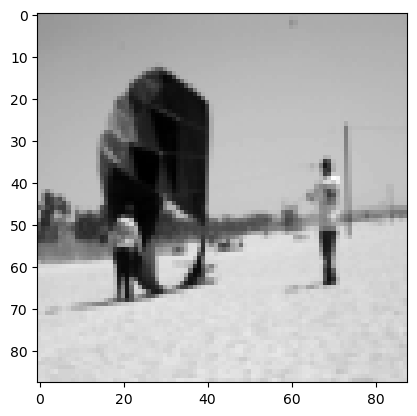

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.37836718559265137, 0.15055207908153534, 0.2848281264305115, 0.28314584493637085], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


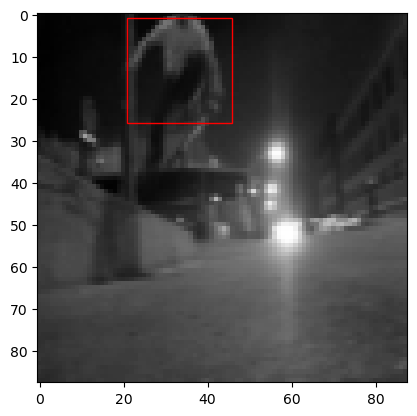

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


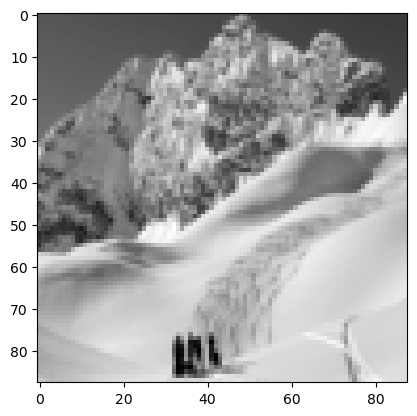

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [1.0, 0.41319531202316284, 0.4404485821723938, 0.15885937213897705, 0.18877461552619934], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [1.0, 0.20907030999660492, 0.6193654537200928, 0.19620312750339508, 0.41890591382980347], [0.0, 0.25, 0.5, 0.0, 0.0], [1.0, 0.6368671655654907, 0.5529321432113647, 0.6786718964576721, 0.8738731145858765], [0.0, 0.75, 0.5, 0.0, 0.0], [1.0, 0.08487500250339508, 0.8232494592666626, 0.16975000500679016, 0.32816192507743835], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


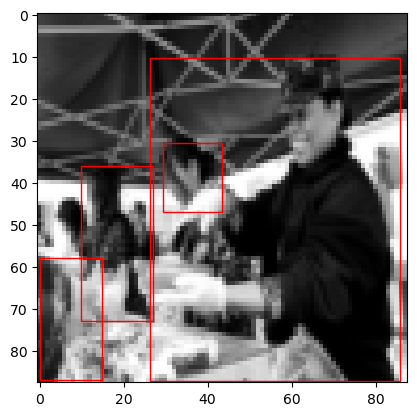

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


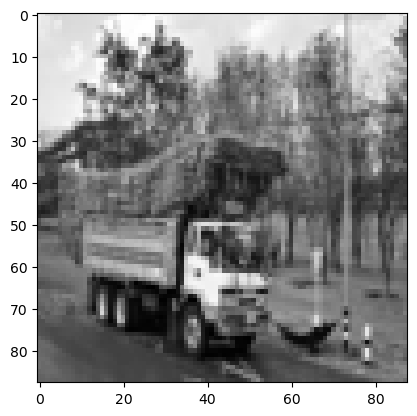

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.42270490527153015, 0.12996093928813934, 0.6096252799034119, 0.2561718821525574], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [1.0, 0.5068501234054565, 0.9370781183242798, 0.6250351071357727, 0.12584374845027924], [0.0, 0.75, 0.75, 0.0, 0.0]]


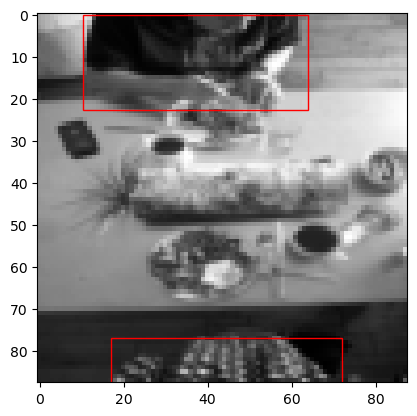

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [1.0, 0.45838281512260437, 0.3075469434261322, 0.10654687136411667, 0.26495304703712463], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [1.0, 0.1062031239271164, 0.5161972045898438, 0.1120000034570694, 0.1476995348930359], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


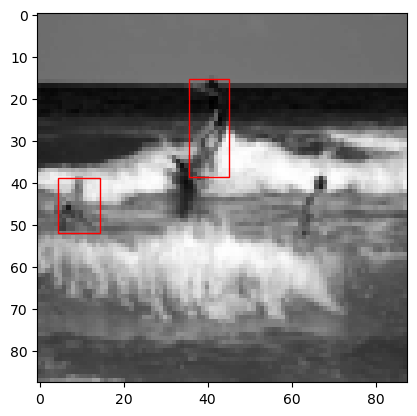

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [1.0, 0.24690625071525574, 0.6559635400772095, 0.1315312534570694, 0.308489590883255], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


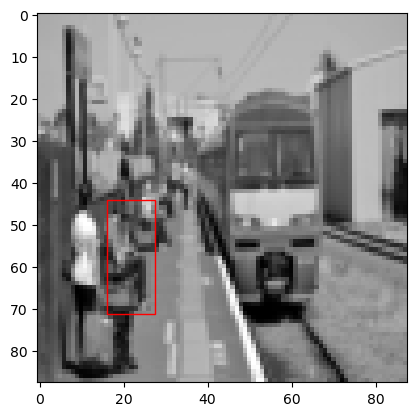

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


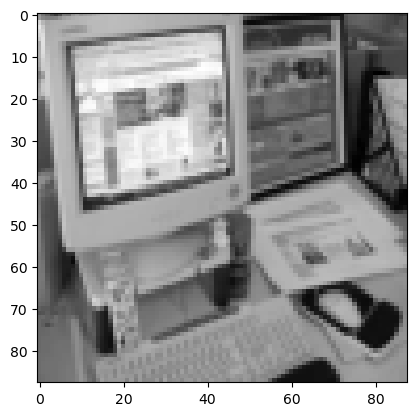

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [1.0, 0.3868800103664398, 0.48442941904067993, 0.2080399990081787, 0.9056156277656555], [1.0, 0.7098299860954285, 0.4840390384197235, 0.31046000123023987, 0.9138438701629639], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [1.0, 0.7849799990653992, 0.5089939832687378, 0.28883999586105347, 0.9325825572013855], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


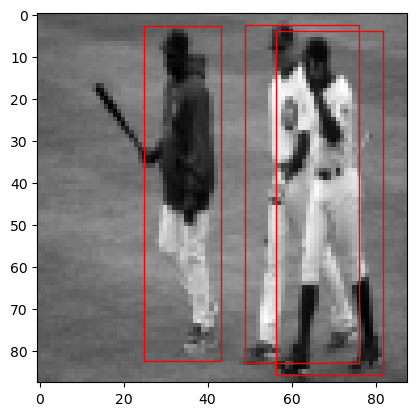

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [1.0, 0.4391121566295624, 0.31251001358032227, 0.4238317608833313, 0.3637000024318695], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [1.0, 0.4552648067474365, 0.7019299864768982, 0.20049844682216644, 0.17282000184059143], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


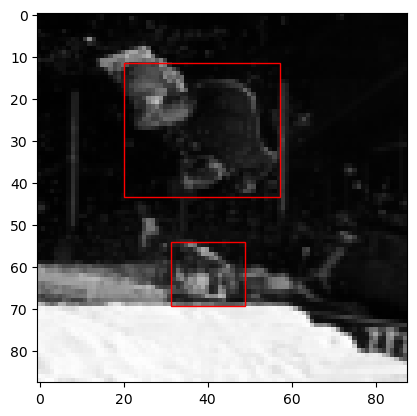

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [1.0, 0.32471874356269836, 0.5253981351852417, 0.13340625166893005, 0.36615926027297974], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


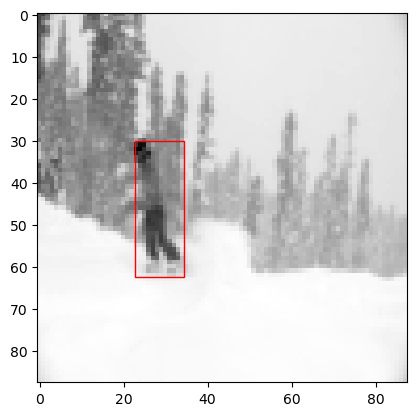

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


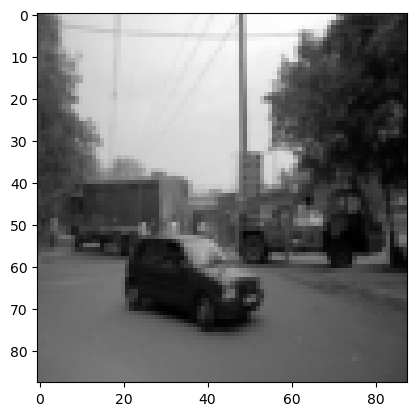

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [1.0, 0.7045546770095825, 0.6704566478729248, 0.5886406302452087, 0.6590866446495056], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


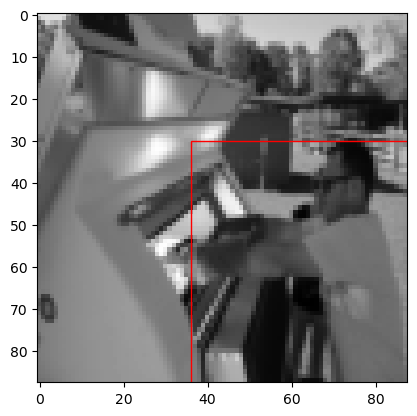

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [1.0, 0.6911875009536743, 0.5446458458900452, 0.2097499966621399, 0.5027916431427002], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


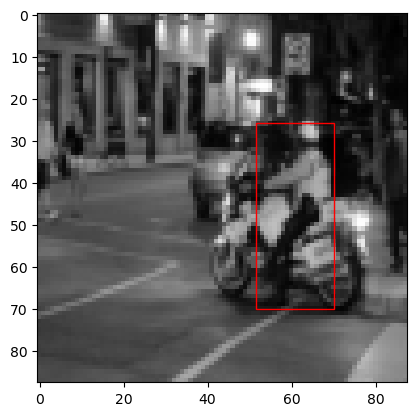

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [1.0, 0.24964843690395355, 0.4353916645050049, 0.17485937476158142, 0.5011166930198669], [1.0, 0.38957032561302185, 0.49437499046325684, 0.1921406239271164, 0.5540500283241272], [0.0, 0.5, 0.25, 0.0, 0.0], [1.0, 0.9225000143051147, 0.42734166979789734, 0.1550000011920929, 0.3640500009059906], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


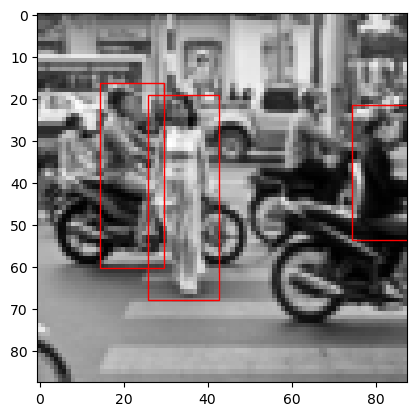

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [1.0, 0.7109609246253967, 0.42798957228660583, 0.14970313012599945, 0.28164583444595337], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


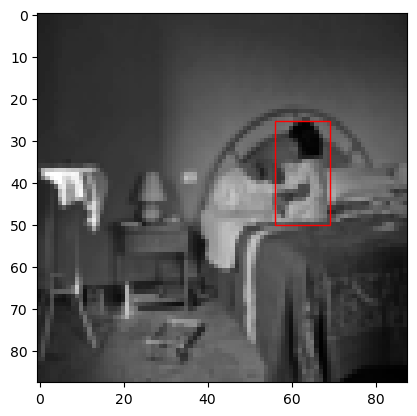

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [1.0, 0.2465859353542328, 0.4242812395095825, 0.1309531182050705, 0.2628124952316284], [1.0, 0.4738749861717224, 0.4153749942779541, 0.11868750303983688, 0.2537499964237213], [1.0, 0.6818437576293945, 0.44969791173934937, 0.18975000083446503, 0.3709791600704193], [1.0, 0.8477578163146973, 0.4921354055404663, 0.15842187404632568, 0.3955208361148834], [1.0, 0.1535625010728836, 0.5022395849227905, 0.1430625021457672, 0.406062513589859], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [1.0, 0.8957343697547913, 0.5527395606040955, 0.2085312455892563, 0.3542291522026062], [1.0, 0.2351093739271164, 0.7606770992279053, 0.4702187478542328, 0.43818750977516174], [1.0, 0.2660468816757202, 0.8558645844459534, 0.5320937633514404, 0.2680208384990692], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


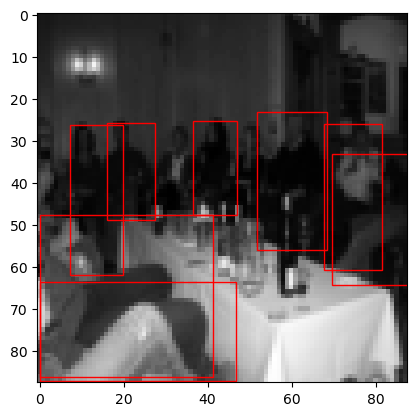

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [1.0, 0.39678123593330383, 0.4988020956516266, 0.13718749582767487, 0.35743749141693115], [1.0, 0.5114765763282776, 0.49809375405311584, 0.10270312428474426, 0.3556458353996277], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


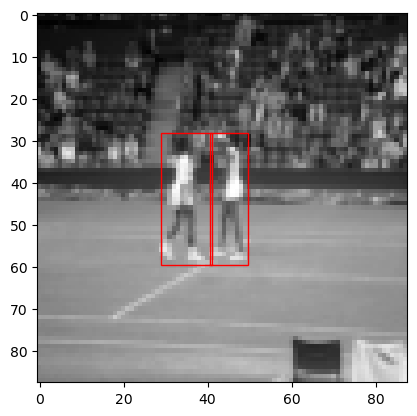

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [1.0, 0.18881000578403473, 0.2686832845211029, 0.2437400072813034, 0.5370818376541138], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [1.0, 0.9032700061798096, 0.305284708738327, 0.12210000306367874, 0.4658719003200531], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


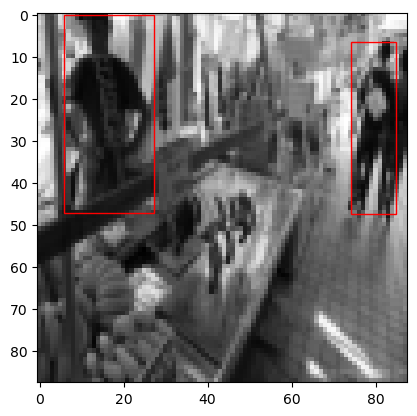

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [1.0, 0.5757343769073486, 0.5337119698524475, 0.11993750184774399, 0.3662997782230377], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


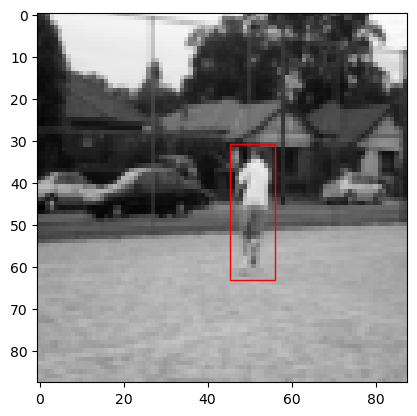

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [1.0, 0.5865156054496765, 0.5641978979110718, 0.41459375619888306, 0.8494374752044678], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


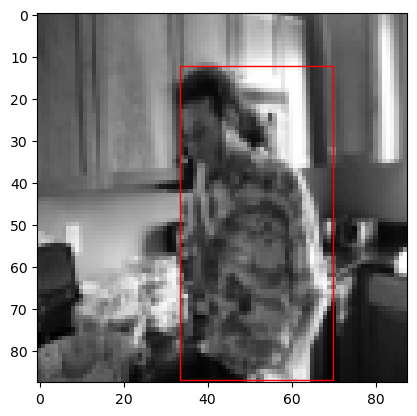

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


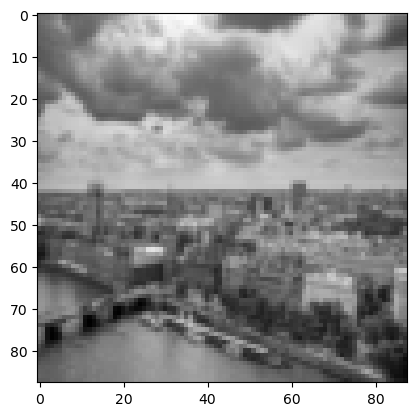

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.25, 0.5, 0.0, 0.0], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


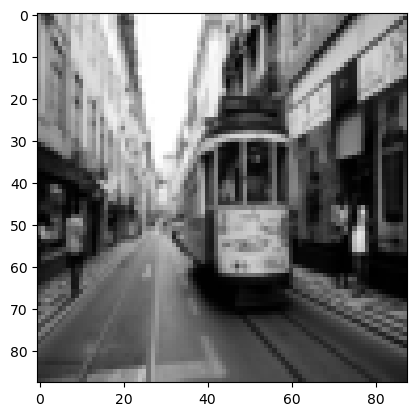

Image shape: torch.Size([1, 88, 88])
Box shape: 16
The first Boxes are: [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.25, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0], [0.0, 0.75, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.25, 0.25, 0.0, 0.0], [0.0, 0.5, 0.25, 0.0, 0.0], [0.0, 0.75, 0.25, 0.0, 0.0], [0.0, 0.0, 0.5, 0.0, 0.0], [1.0, 0.3935000002384186, 0.596791684627533, 0.44731250405311584, 0.7287083268165588], [0.0, 0.5, 0.5, 0.0, 0.0], [0.0, 0.75, 0.5, 0.0, 0.0], [0.0, 0.0, 0.75, 0.0, 0.0], [0.0, 0.25, 0.75, 0.0, 0.0], [0.0, 0.5, 0.75, 0.0, 0.0], [0.0, 0.75, 0.75, 0.0, 0.0]]


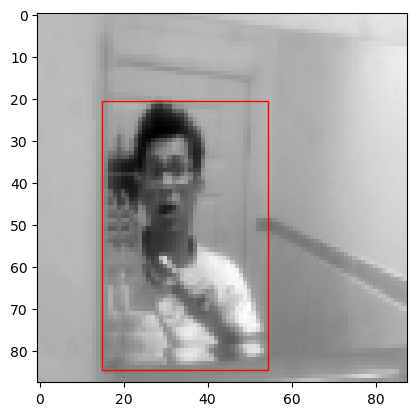

In [14]:
for x,y in val_loader:
    for idx in range(hp['batch_size']):
        real_boxes = cellboxes_to_boxes(y.flatten(start_dim=1),hp['S'])
        print(f"Image shape: {x[idx].shape}")
        print(f"Box shape: {len(real_boxes[idx])}")
        print(f"The first Boxes are: {real_boxes[idx]}")
        plot_image(x[idx].permute(1,2,0).to("cpu"), real_boxes[idx])
    break

# Train Model

In [ ]:
model = YOLOv1().to(hp["device"])

In [ ]:
def test():
    x = torch.randn((8, 3, 256, 256))
    print(model(x).shape)
test()
print(f"Shape should be: [{hp['batch_size']}, {hp['S']*hp['S']*hp['B']*5}]")

In [16]:
optimizer = optim.Adam(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])

In [17]:
loss_fn = YoloLoss()

In [18]:
def intermediate_print(out):
        for idx in range(8):
            bboxes = cellboxes_to_boxes(out, S=hp["S"])
            plot_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes[idx])

In [19]:
def train_fn(train_loader,val_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    ridx = torch.randint(0, len(train_loader), (1,)).item()
    #------------------- Training -------------------#
    mean_train_loss = []
    mean_train_box_loss = []
    mean_train_obj_loss = []
    mean_train_noobj_loss = []
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(hp["device"]), y.to(hp["device"])
        out = model(x)
        loss,box_loss,obj_loss,noobj_loss = loss_fn(out, y)
        mean_train_loss.append(loss.item())
        mean_train_box_loss.append(box_loss.item())
        mean_train_obj_loss.append(obj_loss.item())
        mean_train_noobj_loss.append(noobj_loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if batch_idx == ridx:
            #intermediate_print(batch_idx,ridx,out)
        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean train loss was {sum(mean_train_loss)/len(mean_train_loss)}")
    print(f"Mean train Box loss was {sum(mean_train_box_loss)/len(mean_train_box_loss)}")
    print(f"Mean train Obj loss was {sum(mean_train_obj_loss)/len(mean_train_obj_loss)}")
    print(f"Mean train Noobj loss was {sum(mean_train_noobj_loss)/len(mean_train_noobj_loss)}")

    #------------------- Validation -------------------#
    model.eval()
    mean_val_loss = []
    mean_val_box_loss = []
    mean_val_obj_loss = []
    mean_val_noobj_loss = []
    with torch.no_grad():
        for (x, y) in val_loader:
            x, y = x.to(hp["device"]), y.to(hp["device"])
            out = model(x)
            loss,box_loss,obj_loss,noobj_loss = loss_fn(out, y)
            mean_val_loss.append(loss.item())
            mean_val_box_loss.append(box_loss.item())
            mean_val_obj_loss.append(obj_loss.item())
            mean_val_noobj_loss.append(noobj_loss.item())
    model.train()
    print(f"Mean validation loss was {sum(mean_val_loss)/len(mean_val_loss)}")
    print(f"Mean validation Box loss was {sum(mean_val_box_loss)/len(mean_val_box_loss)}")
    print(f"Mean validation Obj loss was {sum(mean_val_obj_loss)/len(mean_val_obj_loss)}")
    print(f"Mean validation Noobj loss was {sum(mean_val_noobj_loss)/len(mean_val_noobj_loss)}")
    return sum(mean_val_loss)/len(mean_val_loss)

In [20]:
best_loss = 1000
print(f"Train for {hp['num_epochs']} epochs.")
for epoch in range(hp["num_epochs"]):
    print(f"Epoch: {epoch}")
    #------------------- Training IOU -------------------#
    train_ap = get_average_precision(
            train_loader, model,iou_threshold=hp['iou_threshold'], threshold=0.4, split_size=hp["S"],validation_batches=hp['validation_batches'],batch_size=hp['batch_size']
    )
    print(f"Train Average Precision: {train_ap}")
    #------------------- Validation IOU -------------------#
    val_ap = get_average_precision(
            val_loader, model,iou_threshold=hp['iou_threshold'], threshold=0.4, split_size=hp["S"],validation_batches=hp['validation_batches'],batch_size=hp['batch_size']
    )
    print(f"Val Average Precision: {val_ap}")
    #------------------- Training -------------------#
    val_loss = train_fn(train_loader,val_loader, model, optimizer, loss_fn)
    #------------------- Checkpointing -------------------#
    if val_loss <= best_loss:
        best_loss = val_loss
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        print("=> Saving checkpoint")
        torch.save(checkpoint, hp["load_model_file"])

Train for 300 epochs.
Epoch: 0
Train Average Precision: 0.0
Val Average Precision: 0.0


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=97.1] 


Mean train loss was 266.1142254408724
Mean train Box loss was 197.03807263935875
Mean train Obj loss was 31.616419643699054
Mean train Noobj loss was 37.45973300933838
Mean validation loss was 125.9930965647978
Mean validation Box loss was 89.17397671867819
Mean validation Obj loss was 27.558406212750604
Mean validation Noobj loss was 9.2607133584864
=> Saving checkpoint
Epoch: 1
Train Average Precision: 0.04009349271655083
Val Average Precision: 0.04070216044783592


100%|██████████| 2004/2004 [10:17<00:00,  3.25it/s, loss=60.1]


Mean train loss was 146.56054884706904
Mean train Box loss was 100.87008704491956
Mean train Obj loss was 28.22086901626663
Mean train Noobj loss was 17.469592721638328
Mean validation loss was 111.26521352880141
Mean validation Box loss was 75.02172089745017
Mean validation Obj loss was 28.093649864196777
Mean validation Noobj loss was 8.149843154234045
=> Saving checkpoint
Epoch: 2
Train Average Precision: 0.057309217751026154
Val Average Precision: 0.05643652006983757


100%|██████████| 2004/2004 [09:47<00:00,  3.41it/s, loss=50]  


Mean train loss was 124.48500468583401
Mean train Box loss was 83.82569873832657
Mean train Obj loss was 28.040358386829702
Mean train Noobj loss was 12.618947508330354
Mean validation loss was 104.17126506356632
Mean validation Box loss was 68.22135219573974
Mean validation Obj loss was 28.145688455245075
Mean validation Noobj loss was 7.8042246734394745
=> Saving checkpoint
Epoch: 3
Train Average Precision: 0.07144780457019806
Val Average Precision: 0.0952339768409729


100%|██████████| 2004/2004 [09:50<00:00,  3.39it/s, loss=62.8]


Mean train loss was 114.2394446127429
Mean train Box loss was 75.9709128001017
Mean train Obj loss was 27.58366099993388
Mean train Noobj loss was 10.684870851254034
Mean validation loss was 99.72761156418744
Mean validation Box loss was 64.1273995399475
Mean validation Obj loss was 28.25441566214842
Mean validation Noobj loss was 7.3457958894617414
=> Saving checkpoint
Epoch: 4
Train Average Precision: 0.10584522783756256
Val Average Precision: 0.07706318795681


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=51.7]


Mean train loss was 107.68078961439
Mean train Box loss was 70.88385947640546
Mean train Obj loss was 26.928990826635303
Mean train Noobj loss was 9.867939444835077
Mean validation loss was 97.24375888039084
Mean validation Box loss was 62.22787722980275
Mean validation Obj loss was 26.87498025894165
Mean validation Noobj loss was 8.140901200911578
=> Saving checkpoint
Epoch: 5
Train Average Precision: 0.11755143105983734
Val Average Precision: 0.11576833575963974


100%|██████████| 2004/2004 [10:21<00:00,  3.22it/s, loss=58.9]


Mean train loss was 103.34822151998797
Mean train Box loss was 67.56020653414393
Mean train Obj loss was 26.323715353202438
Mean train Noobj loss was 9.464299633355436
Mean validation loss was 95.11602401733398
Mean validation Box loss was 60.362791173598346
Mean validation Obj loss was 28.025366693384505
Mean validation Noobj loss was 6.727865593573626
=> Saving checkpoint
Epoch: 6
Train Average Precision: 0.1136607676744461
Val Average Precision: 0.09410551190376282


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=72.5]


Mean train loss was 100.08862299928646
Mean train Box loss was 64.93789163463843
Mean train Obj loss was 25.997346703877707
Mean train Noobj loss was 9.153384667908599
Mean validation loss was 92.523724230598
Mean validation Box loss was 58.12172963759478
Mean validation Obj loss was 26.531649073432472
Mean validation Noobj loss was 7.870345333043267
=> Saving checkpoint
Epoch: 7
Train Average Precision: 0.14307177066802979
Val Average Precision: 0.08920510113239288


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=54.5]


Mean train loss was 97.43264106933228
Mean train Box loss was 62.825107160442606
Mean train Obj loss was 25.609534289784538
Mean train Noobj loss was 8.997999606732122
Mean validation loss was 91.12308044433594
Mean validation Box loss was 56.937868769028604
Mean validation Obj loss was 26.945999167947207
Mean validation Noobj loss was 7.239212456871481
=> Saving checkpoint
Epoch: 8
Train Average Precision: 0.11507250368595123
Val Average Precision: 0.1108986884355545


100%|██████████| 2004/2004 [10:21<00:00,  3.23it/s, loss=64.6]


Mean train loss was 95.28434746374865
Mean train Box loss was 61.10650438891199
Mean train Obj loss was 25.30742131355042
Mean train Noobj loss was 8.870421732019283
Mean validation loss was 89.58052049524643
Mean validation Box loss was 55.53806311102475
Mean validation Obj loss was 26.632847959855024
Mean validation Noobj loss was 7.409609630528618
=> Saving checkpoint
Epoch: 9
Train Average Precision: 0.14123910665512085
Val Average Precision: 0.1282881200313568


100%|██████████| 2004/2004 [10:23<00:00,  3.22it/s, loss=58.5]


Mean train loss was 93.43921530794003
Mean train Box loss was 59.577570447902716
Mean train Obj loss was 25.05349531145153
Mean train Noobj loss was 8.808149512418492
Mean validation loss was 88.82916414597454
Mean validation Box loss was 55.155362420923566
Mean validation Obj loss was 25.66455514571246
Mean validation Noobj loss was 8.009246064634883
=> Saving checkpoint
Epoch: 10
Train Average Precision: 0.17559044063091278
Val Average Precision: 0.12028250098228455


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=39.5]


Mean train loss was 91.85193228198145
Mean train Box loss was 58.19328465623532
Mean train Obj loss was 24.88936381140155
Mean train Noobj loss was 8.769283839090617
Mean validation loss was 87.91455443887149
Mean validation Box loss was 54.31582281449262
Mean validation Obj loss was 26.072136110417983
Mean validation Noobj loss was 7.526595267127542
=> Saving checkpoint
Epoch: 11
Train Average Precision: 0.11711600422859192
Val Average Precision: 0.13696208596229553


100%|██████████| 2004/2004 [10:21<00:00,  3.22it/s, loss=60]  


Mean train loss was 90.16855261949246
Mean train Box loss was 56.68341870602971
Mean train Obj loss was 24.78209484789424
Mean train Noobj loss was 8.703039039394813
Mean validation loss was 87.04721699882955
Mean validation Box loss was 53.53277418473188
Mean validation Obj loss was 25.820274925231935
Mean validation Noobj loss was 7.694168267530554
=> Saving checkpoint
Epoch: 12
Train Average Precision: 0.14035506546497345
Val Average Precision: 0.11928977817296982


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=60.2]


Mean train loss was 88.7271393340029
Mean train Box loss was 55.427610850381754
Mean train Obj loss was 24.662462293030973
Mean train Noobj loss was 8.637066064718478
Mean validation loss was 86.33672204859117
Mean validation Box loss was 52.85360479915843
Mean validation Obj loss was 25.748695436645956
Mean validation Noobj loss was 7.734421546318952
=> Saving checkpoint
Epoch: 13
Train Average Precision: 0.1682685911655426
Val Average Precision: 0.14952990412712097


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=46.5]


Mean train loss was 87.45511774531381
Mean train Box loss was 54.286980968749454
Mean train Obj loss was 24.595795718019833
Mean train Noobj loss was 8.572341072821093
Mean validation loss was 85.4140972810633
Mean validation Box loss was 51.983633153578815
Mean validation Obj loss was 25.69489480186911
Mean validation Noobj loss was 7.735569794037763
=> Saving checkpoint
Epoch: 14
Train Average Precision: 0.17016726732254028
Val Average Precision: 0.13630525767803192


100%|██████████| 2004/2004 [10:23<00:00,  3.22it/s, loss=46.4]


Mean train loss was 86.24520444203756
Mean train Box loss was 53.06638836337183
Mean train Obj loss was 24.648712175335
Mean train Noobj loss was 8.530103884533256
Mean validation loss was 85.23779734443215
Mean validation Box loss was 51.870440830903895
Mean validation Obj loss was 25.111598357032328
Mean validation Noobj loss was 8.255758537965662
=> Saving checkpoint
Epoch: 15
Train Average Precision: 0.19830626249313354
Val Average Precision: 0.14391741156578064


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=63.2]


Mean train loss was 84.70068651758982
Mean train Box loss was 51.51635939584759
Mean train Obj loss was 24.696705588323628
Mean train Noobj loss was 8.487621576724177
Mean validation loss was 83.78352026097915
Mean validation Box loss was 50.28028646356919
Mean validation Obj loss was 25.85928474594565
Mean validation Noobj loss was 7.643949025518754
=> Saving checkpoint
Epoch: 16
Train Average Precision: 0.1492449790239334
Val Average Precision: 0.17198142409324646


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=46]  


Mean train loss was 83.86792936153755
Mean train Box loss was 50.769854775921786
Mean train Obj loss was 24.665347784579158
Mean train Noobj loss was 8.432726823403211
Mean validation loss was 82.91108811322381
Mean validation Box loss was 49.45313013862161
Mean validation Obj loss was 25.959555850309485
Mean validation Noobj loss was 7.498402503658744
=> Saving checkpoint
Epoch: 17
Train Average Precision: 0.1861475557088852
Val Average Precision: 0.10827360302209854


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=41.8]


Mean train loss was 82.69764234539039
Mean train Box loss was 49.6939802131729
Mean train Obj loss was 24.613109942681774
Mean train Noobj loss was 8.390552155271976
Mean validation loss was 82.77742521622602
Mean validation Box loss was 49.303639681199016
Mean validation Obj loss was 25.92348153731402
Mean validation Noobj loss was 7.550303992103128
=> Saving checkpoint
Epoch: 18
Train Average Precision: 0.15889813005924225
Val Average Precision: 0.12494636327028275


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=44]  


Mean train loss was 81.75819188344502
Mean train Box loss was 48.86121361555453
Mean train Obj loss was 24.5301222068345
Mean train Noobj loss was 8.36685601346745
Mean validation loss was 82.68961121054257
Mean validation Box loss was 49.12564848731546
Mean validation Obj loss was 26.731554738213035
Mean validation Noobj loss was 6.832407952757443
=> Saving checkpoint
Epoch: 19
Train Average Precision: 0.16729803383350372
Val Average Precision: 0.13538751006126404


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=59.4]


Mean train loss was 80.91945796479246
Mean train Box loss was 48.134970648797925
Mean train Obj loss was 24.394855017671567
Mean train Noobj loss was 8.389632145087877
Mean validation loss was 82.02599253373988
Mean validation Box loss was 48.88279767036438
Mean validation Obj loss was 25.097449989879834
Mean validation Noobj loss was 8.045744856666117
=> Saving checkpoint
Epoch: 20
Train Average Precision: 0.1727582812309265
Val Average Precision: 0.12962961196899414


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=29.1]


Mean train loss was 80.07535688225143
Mean train Box loss was 47.398156871338806
Mean train Obj loss was 24.28252762377619
Mean train Noobj loss was 8.394672355252112
Mean validation loss was 82.2294204936308
Mean validation Box loss was 48.66237054712632
Mean validation Obj loss was 26.662429012971767
Mean validation Noobj loss was 6.904621393540326
Epoch: 21
Train Average Precision: 0.1767192780971527
Val Average Precision: 0.13910019397735596


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=52.2]


Mean train loss was 79.20410393431277
Mean train Box loss was 46.568288726007154
Mean train Obj loss was 24.258481425915413
Mean train Noobj loss was 8.377333682692218
Mean validation loss was 81.70367068122415
Mean validation Box loss was 48.53366873124067
Mean validation Obj loss was 25.63606648725622
Mean validation Noobj loss was 7.533935274797328
=> Saving checkpoint
Epoch: 22
Train Average Precision: 0.20128804445266724
Val Average Precision: 0.16177722811698914


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=43.6]


Mean train loss was 78.43777227687265
Mean train Box loss was 45.90126418020435
Mean train Obj loss was 24.20608694919807
Mean train Noobj loss was 8.330421167933299
Mean validation loss was 81.30290093141444
Mean validation Box loss was 48.146832410027
Mean validation Obj loss was 24.9092498106115
Mean validation Noobj loss was 8.246818014453439
=> Saving checkpoint
Epoch: 23
Train Average Precision: 0.2387462705373764
Val Average Precision: 0.1634884774684906


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=39.8]


Mean train loss was 77.61628828981442
Mean train Box loss was 45.22281181122253
Mean train Obj loss was 24.020071978102663
Mean train Noobj loss was 8.373404484547065
Mean validation loss was 82.07808696522432
Mean validation Box loss was 49.068176359288834
Mean validation Obj loss was 25.586301814808564
Mean validation Noobj loss was 7.423609258146847
Epoch: 24
Train Average Precision: 0.2151036113500595
Val Average Precision: 0.13665027916431427


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=52.7]


Mean train loss was 77.07803996499189
Mean train Box loss was 44.71300873404253
Mean train Obj loss was 24.009409588016197
Mean train Noobj loss was 8.355621686476672
Mean validation loss was 81.4711513968075
Mean validation Box loss was 48.26029949188232
Mean validation Obj loss was 26.07793692420511
Mean validation Noobj loss was 7.13291521913865
Epoch: 25
Train Average Precision: 0.17152054607868195
Val Average Precision: 0.14608649909496307


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=30.3]


Mean train loss was 76.35626105348507
Mean train Box loss was 44.08574369615186
Mean train Obj loss was 23.934036373378273
Mean train Noobj loss was 8.336481031781423
Mean validation loss was 81.40822674246395
Mean validation Box loss was 48.402583672018615
Mean validation Obj loss was 24.472268542121437
Mean validation Noobj loss was 8.533374612471636
Epoch: 26
Train Average Precision: 0.19294847548007965
Val Average Precision: 0.15481579303741455


100%|██████████| 2004/2004 [10:23<00:00,  3.22it/s, loss=55.4]


Mean train loss was 75.65678890022689
Mean train Box loss was 43.45568791596951
Mean train Obj loss was 23.84785342502023
Mean train Noobj loss was 8.353247610632769
Mean validation loss was 81.22788689557244
Mean validation Box loss was 48.22894964779125
Mean validation Obj loss was 24.70443774952608
Mean validation Noobj loss was 8.294498940075146
=> Saving checkpoint
Epoch: 27
Train Average Precision: 0.18175359070301056
Val Average Precision: 0.14097954332828522


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=53.2]


Mean train loss was 75.1852344771821
Mean train Box loss was 43.039619760836906
Mean train Obj loss was 23.788787030888177
Mean train Noobj loss was 8.356827682839658
Mean validation loss was 82.45805855919333
Mean validation Box loss was 48.90774920968448
Mean validation Obj loss was 27.37046324786018
Mean validation Noobj loss was 6.179845766460194
Epoch: 28
Train Average Precision: 0.19035837054252625
Val Average Precision: 0.15169405937194824


100%|██████████| 2004/2004 [10:22<00:00,  3.22it/s, loss=28.4]


Mean train loss was 74.42907949074538
Mean train Box loss was 42.37444721534105
Mean train Obj loss was 23.704959528174943
Mean train Noobj loss was 8.34967278101725
Mean validation loss was 81.39261979495778
Mean validation Box loss was 48.420637231714586
Mean validation Obj loss was 25.362003923864926
Mean validation Noobj loss was 7.609978372910444
Epoch: 29
Train Average Precision: 0.1985657513141632
Val Average Precision: 0.14308884739875793


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=45.2]


Mean train loss was 73.87834144447616
Mean train Box loss was 41.85732651613429
Mean train Obj loss was 23.703712398658492
Mean train Noobj loss was 8.31730258619476
Mean validation loss was 82.3226266075583
Mean validation Box loss was 49.15773561702055
Mean validation Obj loss was 25.152771997451783
Mean validation Noobj loss was 8.01211972657372
Epoch: 30
Train Average Precision: 0.15307514369487762
Val Average Precision: 0.16186048090457916


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=65.6]


Mean train loss was 73.1948442211646
Mean train Box loss was 41.22644127485995
Mean train Obj loss was 23.643185552246795
Mean train Noobj loss was 8.325217349086692
Mean validation loss was 81.24465581108542
Mean validation Box loss was 48.065942158418544
Mean validation Obj loss was 25.79513740118812
Mean validation Noobj loss was 7.3835758679053365
Epoch: 31
Train Average Precision: 0.21437887847423553
Val Average Precision: 0.12830370664596558


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=39.3]


Mean train loss was 72.86597174798658
Mean train Box loss was 40.968321949659945
Mean train Obj loss was 23.58657101861493
Mean train Noobj loss was 8.311078805647448
Mean validation loss was 81.28113378636978
Mean validation Box loss was 48.17496635212618
Mean validation Obj loss was 26.056035636453068
Mean validation Noobj loss was 7.05013173047234
Epoch: 32
Train Average Precision: 0.2127080261707306
Val Average Precision: 0.12856964766979218


100%|██████████| 2004/2004 [10:23<00:00,  3.21it/s, loss=38]  


Mean train loss was 72.31403810154654
Mean train Box loss was 40.49655442037982
Mean train Obj loss was 23.50052584478717
Mean train Noobj loss was 8.31695790990384
Mean validation loss was 81.5664976344389
Mean validation Box loss was 48.790266435286576
Mean validation Obj loss was 25.425452686758604
Mean validation Noobj loss was 7.350778581114376
Epoch: 33
Train Average Precision: 0.2294810712337494
Val Average Precision: 0.1874503195285797


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=48.5]


Mean train loss was 71.6193411326456
Mean train Box loss was 39.879840724244566
Mean train Obj loss was 23.431618765680614
Mean train Noobj loss was 8.307881613215525
Mean validation loss was 81.52963382496553
Mean validation Box loss was 48.69605498594396
Mean validation Obj loss was 24.769306746651143
Mean validation Noobj loss was 8.064272555182962
Epoch: 34
Train Average Precision: 0.22529706358909607
Val Average Precision: 0.08268261700868607


100%|██████████| 2004/2004 [10:23<00:00,  3.22it/s, loss=52.7]


Mean train loss was 71.19369641225971
Mean train Box loss was 39.48480631634147
Mean train Obj loss was 23.405666315626956
Mean train Noobj loss was 8.303223925198386
Mean validation loss was 81.88938313652487
Mean validation Box loss was 48.654399815727686
Mean validation Obj loss was 26.519216837602503
Mean validation Noobj loss was 6.71576658557443
Epoch: 35
Train Average Precision: 0.21013760566711426
Val Average Precision: 0.11271969228982925


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=45.7]


Mean train loss was 70.7722935343455
Mean train Box loss was 39.148544123072824
Mean train Obj loss was 23.315933091911727
Mean train Noobj loss was 8.307816338158416
Mean validation loss was 81.67728462780224
Mean validation Box loss was 48.696034768048456
Mean validation Obj loss was 25.16514681928298
Mean validation Noobj loss was 7.816103050288032
Epoch: 36
Train Average Precision: 0.2363848239183426
Val Average Precision: 0.13900405168533325


100%|██████████| 2004/2004 [10:26<00:00,  3.20it/s, loss=26.5]


Mean train loss was 70.16347326442391
Mean train Box loss was 38.630941075955086
Mean train Obj loss was 23.264427891748394
Mean train Noobj loss was 8.268104322180301
Mean validation loss was 81.70456621506635
Mean validation Box loss was 48.86244484396542
Mean validation Obj loss was 24.97016762565164
Mean validation Noobj loss was 7.871953798742855
Epoch: 37
Train Average Precision: 0.18116432428359985
Val Average Precision: 0.15500912070274353


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=59.6]


Mean train loss was 69.69346588386033
Mean train Box loss was 38.22645344134576
Mean train Obj loss was 23.16676444160248
Mean train Noobj loss was 8.300248047786797
Mean validation loss was 81.57634771010456
Mean validation Box loss was 48.73892285964068
Mean validation Obj loss was 25.18466313306023
Mean validation Noobj loss was 7.652761856948628
Epoch: 38
Train Average Precision: 0.23379917442798615
Val Average Precision: 0.13309422135353088


100%|██████████| 2004/2004 [10:23<00:00,  3.22it/s, loss=46.1]


Mean train loss was 69.25520076104505
Mean train Box loss was 37.84907805086848
Mean train Obj loss was 23.144133421713246
Mean train Noobj loss was 8.261989441698422
Mean validation loss was 81.60673658707563
Mean validation Box loss was 48.627434388329
Mean validation Obj loss was 25.62716921077055
Mean validation Noobj loss was 7.352133578412673
Epoch: 39
Train Average Precision: 0.20366553962230682
Val Average Precision: 0.1524355411529541


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=49.6]


Mean train loss was 68.82205048102342
Mean train Box loss was 37.45224405477147
Mean train Obj loss was 23.079449750706107
Mean train Noobj loss was 8.290356643185644
Mean validation loss was 82.06884619768928
Mean validation Box loss was 49.04799316069659
Mean validation Obj loss was 25.46489831980537
Mean validation Noobj loss was 7.555954809749828
Epoch: 40
Train Average Precision: 0.22170786559581757
Val Average Precision: 0.12384112179279327


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=42.2]


Mean train loss was 68.4726566668756
Mean train Box loss was 37.18233086724957
Mean train Obj loss was 23.054998904645085
Mean train Noobj loss was 8.235326867141648
Mean validation loss was 82.14031062406652
Mean validation Box loss was 49.18968290441177
Mean validation Obj loss was 25.415066197339225
Mean validation Noobj loss was 7.535561261457556
Epoch: 41
Train Average Precision: 0.2498934119939804
Val Average Precision: 0.16573700308799744


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=30.5]


Mean train loss was 67.9235595885865
Mean train Box loss was 36.713571403792756
Mean train Obj loss was 22.9120749094767
Mean train Noobj loss was 8.297913289831547
Mean validation loss was 82.57467184627757
Mean validation Box loss was 49.73298299452838
Mean validation Obj loss was 25.592204565160415
Mean validation Noobj loss was 7.249484404395608
Epoch: 42
Train Average Precision: 0.2063719779253006
Val Average Precision: 0.17267978191375732


100%|██████████| 2004/2004 [10:25<00:00,  3.20it/s, loss=32.6]


Mean train loss was 67.62047385598372
Mean train Box loss was 36.468490045703575
Mean train Obj loss was 22.89195704793264
Mean train Noobj loss was 8.260026758778357
Mean validation loss was 82.31144682940315
Mean validation Box loss was 49.27653745763442
Mean validation Obj loss was 26.126617431640625
Mean validation Noobj loss was 6.908292191168841
Epoch: 43
Train Average Precision: 0.18107019364833832
Val Average Precision: 0.1397765725851059


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=31.6]


Mean train loss was 67.35325120975395
Mean train Box loss was 36.23969236248268
Mean train Obj loss was 22.88746497302712
Mean train Noobj loss was 8.226093931588347
Mean validation loss was 81.89550543392406
Mean validation Box loss was 49.01400628370397
Mean validation Obj loss was 24.61963557776283
Mean validation Noobj loss was 8.26186299604528
Epoch: 44
Train Average Precision: 0.240577831864357
Val Average Precision: 0.14375600218772888


100%|██████████| 2004/2004 [10:25<00:00,  3.21it/s, loss=27.7]


Mean train loss was 66.90905782848061
Mean train Box loss was 35.8333621496212
Mean train Obj loss was 22.81137380818883
Mean train Noobj loss was 8.264321884233318
Mean validation loss was 81.8215227800257
Mean validation Box loss was 48.889776611328124
Mean validation Obj loss was 24.996413469314575
Mean validation Noobj loss was 7.935333598361296
Epoch: 45
Train Average Precision: 0.22156202793121338
Val Average Precision: 0.1354351043701172


100%|██████████| 2004/2004 [10:25<00:00,  3.20it/s, loss=28.1]


Mean train loss was 66.45868062592314
Mean train Box loss was 35.487715802982656
Mean train Obj loss was 22.754976310177952
Mean train Noobj loss was 8.215988495154772
Mean validation loss was 82.24219280691707
Mean validation Box loss was 49.280059814453125
Mean validation Obj loss was 25.357336150898654
Mean validation Noobj loss was 7.604796955164741
Epoch: 46
Train Average Precision: 0.2340558022260666
Val Average Precision: 0.14257556200027466


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=30.1]


Mean train loss was 66.3588057868257
Mean train Box loss was 35.450900320997256
Mean train Obj loss was 22.65223315756716
Mean train Noobj loss was 8.255672322537846
Mean validation loss was 82.31668768490061
Mean validation Box loss was 49.14594297970042
Mean validation Obj loss was 25.35778770867516
Mean validation Noobj loss was 7.812956910974839
Epoch: 47
Train Average Precision: 0.21199281513690948
Val Average Precision: 0.1175934299826622


100%|██████████| 2004/2004 [10:25<00:00,  3.20it/s, loss=29.9]


Mean train loss was 65.83612067304448
Mean train Box loss was 34.97752521946997
Mean train Obj loss was 22.639286915461224
Mean train Noobj loss was 8.219308586177712
Mean validation loss was 82.41014753229477
Mean validation Box loss was 49.52255250145407
Mean validation Obj loss was 24.710904587016387
Mean validation Noobj loss was 8.176690649986266
Epoch: 48
Train Average Precision: 0.23077984154224396
Val Average Precision: 0.13286586105823517


100%|██████████| 2004/2004 [10:25<00:00,  3.20it/s, loss=29.8]


Mean train loss was 65.45483435366206
Mean train Box loss was 34.6500782338445
Mean train Obj loss was 22.58064073907163
Mean train Noobj loss was 8.224115376462956
Mean validation loss was 82.31839554730584
Mean validation Box loss was 49.36643280141494
Mean validation Obj loss was 25.510846368004295
Mean validation Noobj loss was 7.441116767771104
Epoch: 49
Train Average Precision: 0.21291765570640564
Val Average Precision: 0.1134631410241127


100%|██████████| 2004/2004 [10:26<00:00,  3.20it/s, loss=46.5]


Mean train loss was 65.26824636135748
Mean train Box loss was 34.535267243604224
Mean train Obj loss was 22.517278444743205
Mean train Noobj loss was 8.215700666347663
Mean validation loss was 82.29430400623994
Mean validation Box loss was 49.23512568754308
Mean validation Obj loss was 25.82986447951373
Mean validation Noobj loss was 7.229313827963436
Epoch: 50
Train Average Precision: 0.21206942200660706
Val Average Precision: 0.16762658953666687


100%|██████████| 2004/2004 [10:25<00:00,  3.21it/s, loss=38.8]


Mean train loss was 64.85626347288638
Mean train Box loss was 34.19664069944751
Mean train Obj loss was 22.468548619104716
Mean train Noobj loss was 8.191074145292331
Mean validation loss was 82.40505815393784
Mean validation Box loss was 49.38146513770609
Mean validation Obj loss was 25.581256984261906
Mean validation Noobj loss was 7.442336214289946
Epoch: 51
Train Average Precision: 0.22441567480564117
Val Average Precision: 0.12517477571964264


100%|██████████| 2004/2004 [10:26<00:00,  3.20it/s, loss=35.5]


Mean train loss was 64.51563238383767
Mean train Box loss was 33.89488993290656
Mean train Obj loss was 22.43465056438408
Mean train Noobj loss was 8.186091778758994
Mean validation loss was 82.91052796700421
Mean validation Box loss was 49.810093115357795
Mean validation Obj loss was 25.92637990222258
Mean validation Noobj loss was 7.174054855458877
Epoch: 52
Train Average Precision: 0.262970894575119
Val Average Precision: 0.16849368810653687


100%|██████████| 2004/2004 [10:24<00:00,  3.21it/s, loss=29.8]


Mean train loss was 64.24808781256456
Mean train Box loss was 33.67817543557066
Mean train Obj loss was 22.392383360815142
Mean train Noobj loss was 8.177529011181967
Mean validation loss was 82.74941588009105
Mean validation Box loss was 49.755353882733516
Mean validation Obj loss was 25.66603037890266
Mean validation Noobj loss was 7.328031170368194
Epoch: 53
Train Average Precision: 0.19190746545791626
Val Average Precision: 0.151932030916214


100%|██████████| 2004/2004 [10:26<00:00,  3.20it/s, loss=23.2]


Mean train loss was 63.918106797688495
Mean train Box loss was 33.417738824547406
Mean train Obj loss was 22.331531728099208
Mean train Noobj loss was 8.168836244565998
Mean validation loss was 82.30059989480411
Mean validation Box loss was 49.236397642247816
Mean validation Obj loss was 25.242869825924146
Mean validation Noobj loss was 7.82133216717664
Epoch: 54
Train Average Precision: 0.2584590017795563
Val Average Precision: 0.14960265159606934


100%|██████████| 2004/2004 [10:25<00:00,  3.20it/s, loss=39.5]


Mean train loss was 63.57923889160156
Mean train Box loss was 33.147894173563124
Mean train Obj loss was 22.25304016667212
Mean train Noobj loss was 8.17830447593849
Mean validation loss was 82.34769290475285
Mean validation Box loss was 49.29221205430872
Mean validation Obj loss was 25.261593274509206
Mean validation Noobj loss was 7.793887568922604
Epoch: 55
Train Average Precision: 0.22886723279953003
Val Average Precision: 0.12263321876525879


100%|██████████| 2004/2004 [10:10<00:00,  3.28it/s, loss=30.9]


Mean train loss was 63.46113795053935
Mean train Box loss was 33.0271703054805
Mean train Obj loss was 22.3084780855807
Mean train Noobj loss was 8.125489467394328
Mean validation loss was 83.2725746940164
Mean validation Box loss was 49.89911370557897
Mean validation Obj loss was 26.431334388957303
Mean validation Noobj loss was 6.942126237644869
Epoch: 56
Train Average Precision: 0.2284809947013855
Val Average Precision: 0.13464286923408508


  6%|▌         | 120/2004 [00:35<09:11,  3.42it/s, loss=59.5]

KeyboardInterrupt



# Validation

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
model = YOLOv1().to(hp["device"])
optimizer = optim.Adam(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])
checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
}
load_checkpoint(torch.load(hp['load_model_file']), model, optimizer)

In [21]:
def validation_print(out,y):
    bboxes = cellboxes_to_boxes(out, S=hp["S"])
    real_boxes = cellboxes_to_boxes(y.flatten(start_dim=1),hp['S'])
    for idx in range(hp['batch_size']):
        best_boxes = non_max_suppression(bboxes[idx],hp['threshold'])
        plot_image(x[idx].permute(1, 2, 0).to("cpu"), best_boxes,real_boxes[idx])

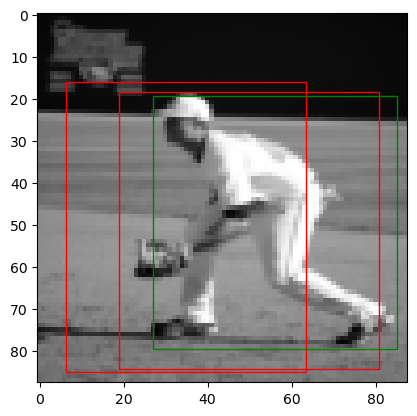

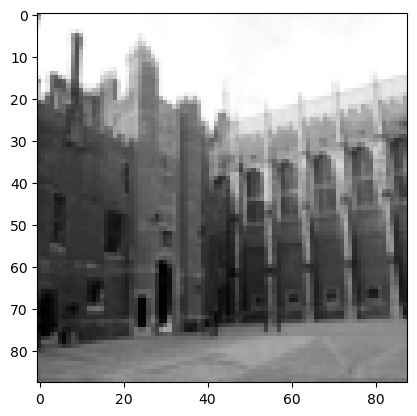

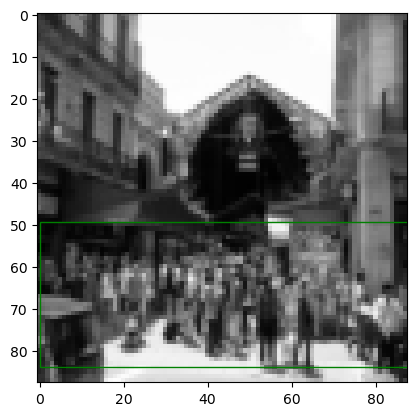

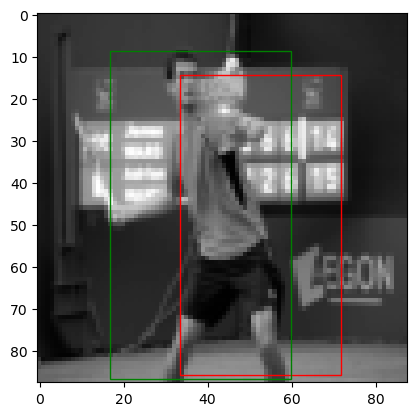

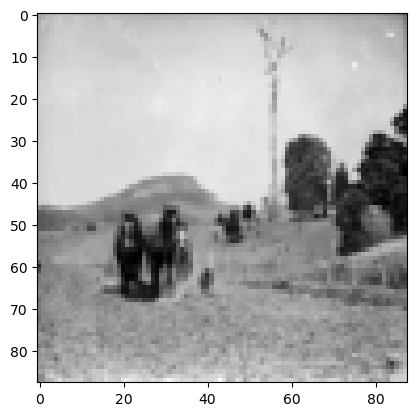

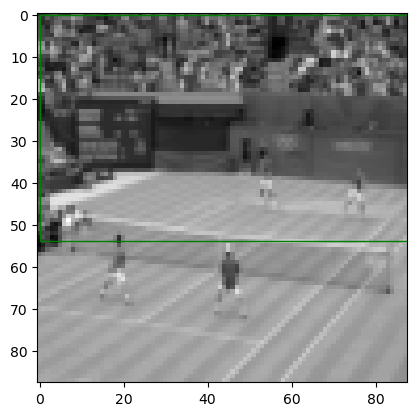

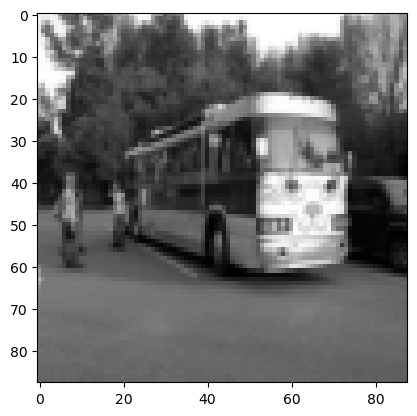

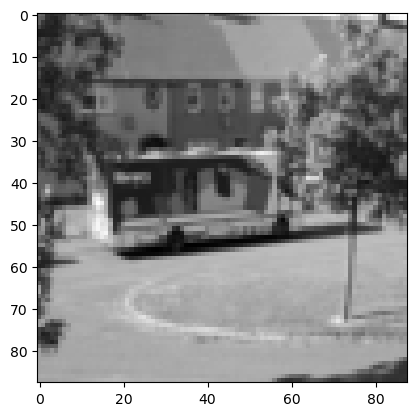

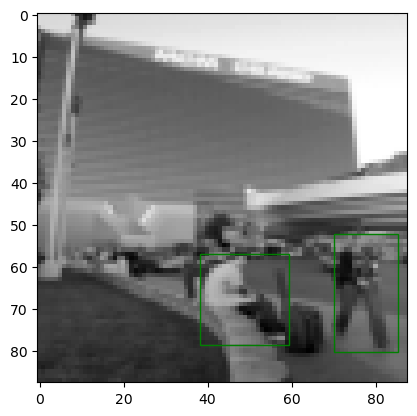

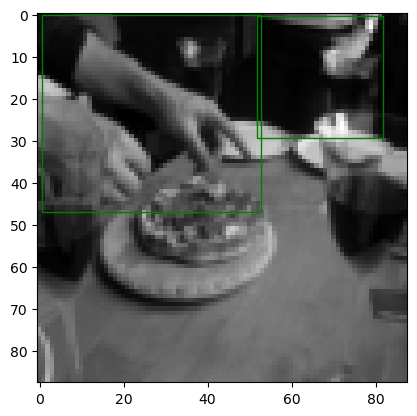

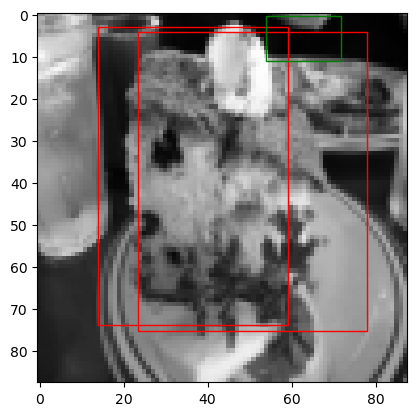

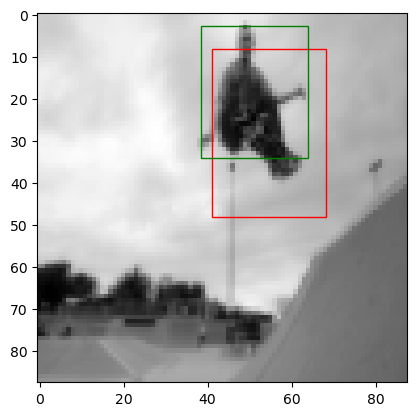

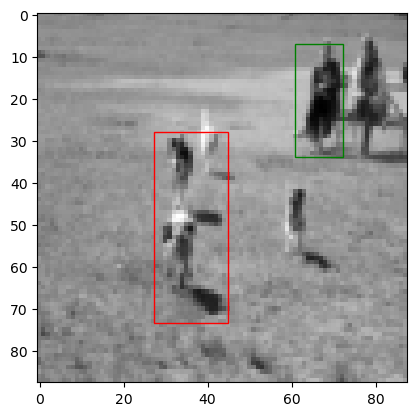

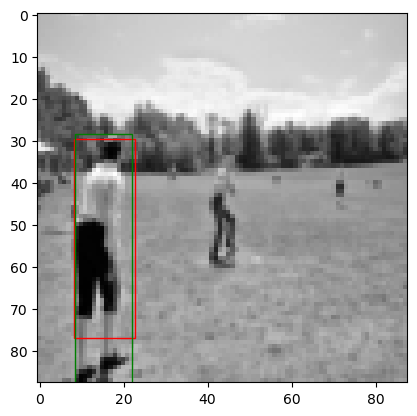

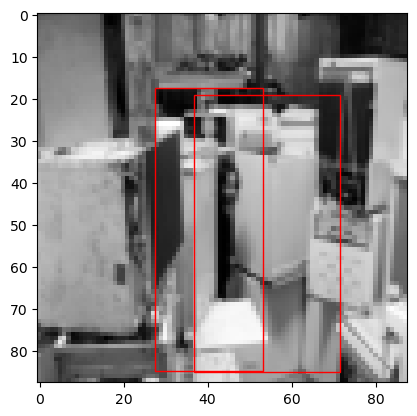

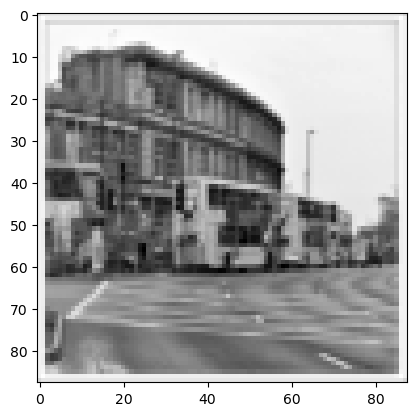

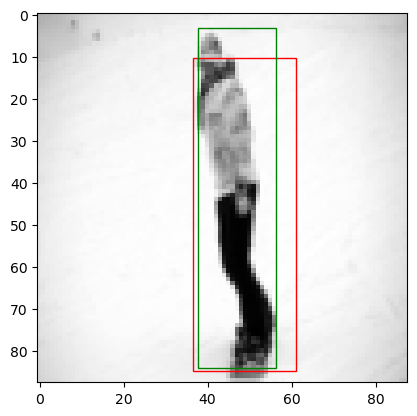

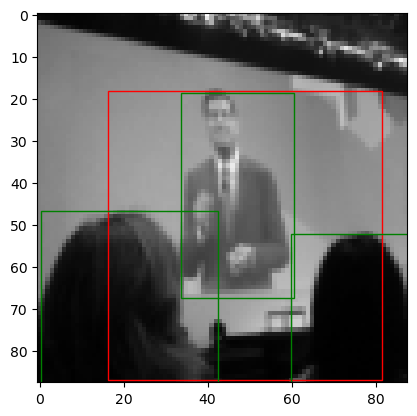

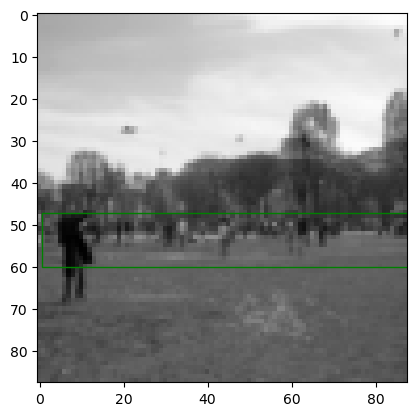

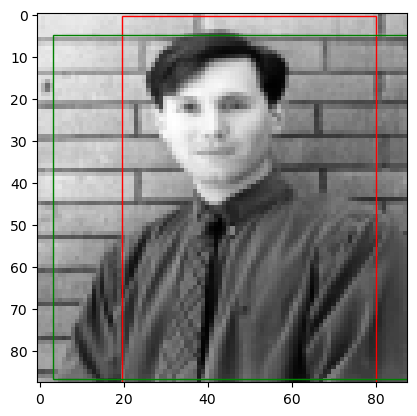

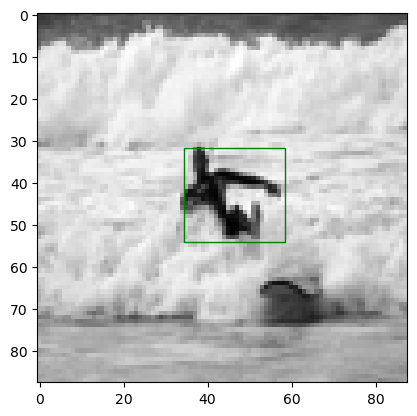

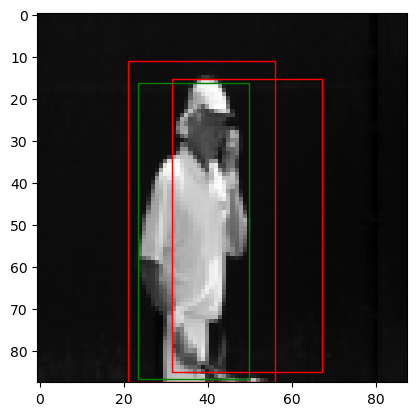

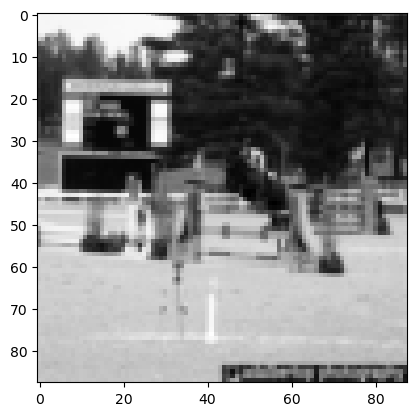

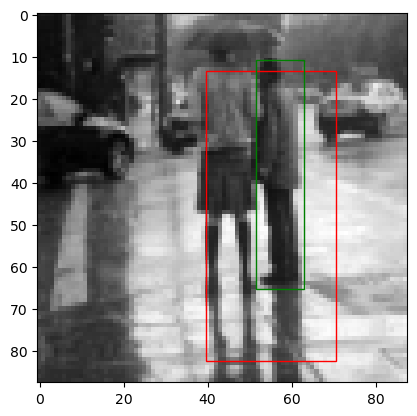

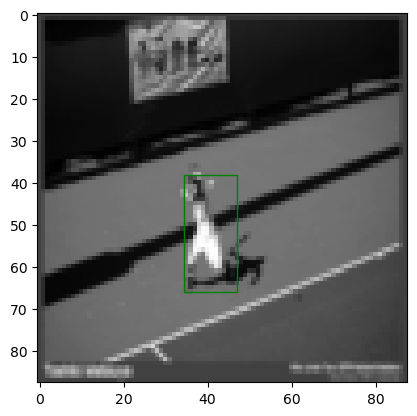

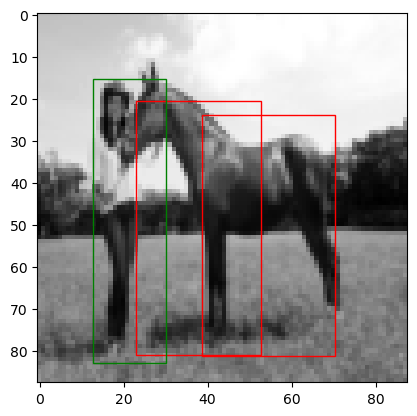

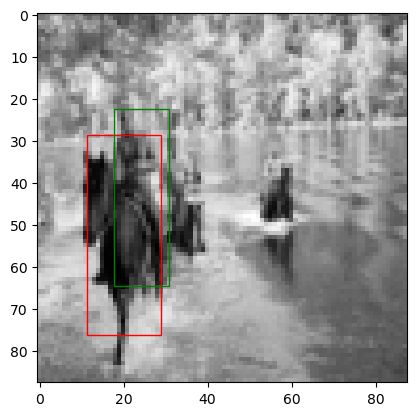

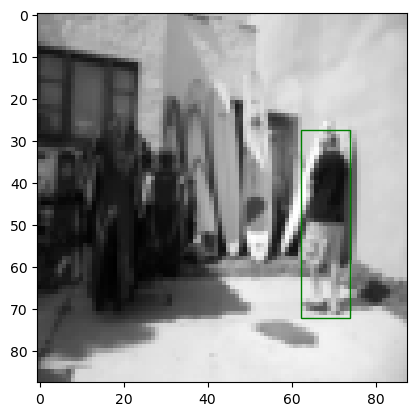

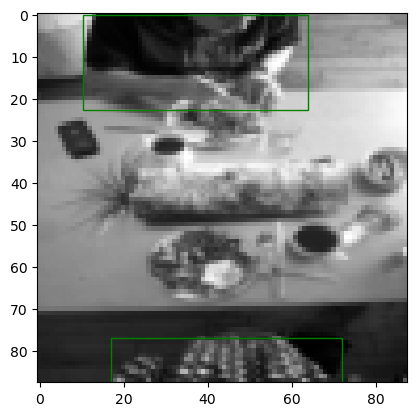

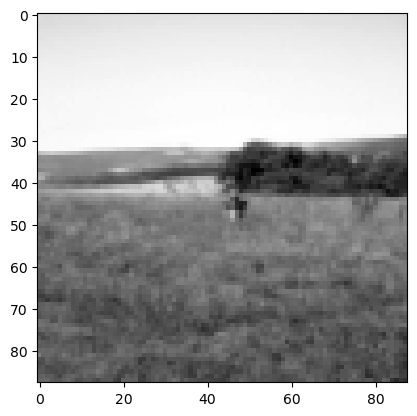

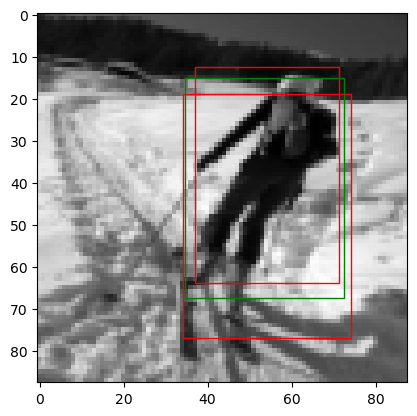

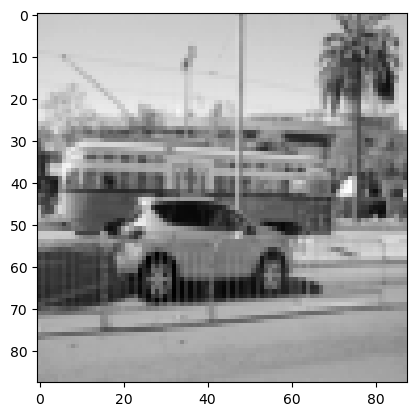

YOLOv1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): CNNBlock(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): CNNBlock(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (4): CNNBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 

In [22]:
model.eval()
with torch.no_grad():
    for (x, y) in val_loader:
        x= x.to(hp['device'])
        out = model(x)
        validation_print(out,y)
        break
model.train()

In [ ]:
resulting_iou = get_average_precision(
            val_loader, model,iou_threshold=hp['iou_threshold'], threshold=0.4, split_size=hp["S"], validation_batches=hp['validation_batches'],batch_size=hp['batch_size']
)
print(f"Resulting Average Precision: {resulting_iou}")

In [ ]:
param_size = 0
number_parameter = 0
for param in model.parameters():
    number_parameter += param.nelement()
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print(f"#Parameter: {number_parameter}")

In [ ]:
model = YOLOv1()
summary(model,input_size=[(1,88,88)])

In [6]:
half_model = model.half()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.HalfTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [5]:
for n,p in model.named_parameters():
    print(n, ": ",p.dtype)

darknet.0.conv.weight :  torch.float32
darknet.0.batchnorm.weight :  torch.float32
darknet.0.batchnorm.bias :  torch.float32
darknet.1.conv.weight :  torch.float32
darknet.1.batchnorm.weight :  torch.float32
darknet.1.batchnorm.bias :  torch.float32
darknet.3.conv.weight :  torch.float32
darknet.3.batchnorm.weight :  torch.float32
darknet.3.batchnorm.bias :  torch.float32
darknet.4.conv.weight :  torch.float32
darknet.4.batchnorm.weight :  torch.float32
darknet.4.batchnorm.bias :  torch.float32
darknet.6.conv.weight :  torch.float32
darknet.6.batchnorm.weight :  torch.float32
darknet.6.batchnorm.bias :  torch.float32
darknet.7.conv.weight :  torch.float32
darknet.7.batchnorm.weight :  torch.float32
darknet.7.batchnorm.bias :  torch.float32
darknet.9.conv.weight :  torch.float32
darknet.9.batchnorm.weight :  torch.float32
darknet.9.batchnorm.bias :  torch.float32
darknet.10.conv.weight :  torch.float32
darknet.10.batchnorm.weight :  torch.float32
darknet.10.batchnorm.bias :  torch.float